In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [63]:
class N_Armed_Bandit():
    
    def __init__(self,game,play,
                 n_arms,control_paras,
                 burning_period,
                 softmax=1):
        
        # times of game
        self.game = game
        
        # times of playround during each game
        self.play = play
        
        # how many levers
        self.n_arms = n_arms
        
        # epsilon for epsilon-greedy, tau(tempreture) for softmax
        self.control_paras = control_paras
        
        # how many rounds of burning period are included during the simulation
        self.burning_period = burning_period
        
        # n_unique of control_paras decisdes how many methods are competing
        self.n_group = len(control_paras)
        
        # whether use softmax to select action
        self.softmax = softmax
        
    def __DataRestoration(self):
        
        # True rewards, fixed for each game
        self.true_rwd = np.random.normal(0,1,self.n_arms)
        
        # Estimated reward, update after each play
        self.estimated_rwd = np.zeros((self.n_group,self.n_arms))
        
        # Record total reward of each action, update after each play
        self.acc_action_rwd = np.zeros((self.n_group,self.n_arms))           
        
        # Track the times each action taken
        self.action_times = np.zeros((self.n_group,self.n_arms))
        
        # Track the optimal action reward
        self.optimal_action_rwd_track = np.zeros((self.n_group,self.play))
        
        # Track the accumulated reward during the play
        self.acc_rwd_track = np.zeros((self.n_group,self.play))
        
        
    def Softmax_selection(self,Q_t):
        
        # reshape paras, to adapt numpy array computation
        tau = np.array(self.control_paras).reshape(self.n_group,-1)
        
        numerator = np.exp(Q_t/tau)
        denominator = numerator.sum(axis=1,keepdims=True)
        softmax_prob = numerator/denominator
        return softmax_prob
        
        
    def Choose_action(self,p):
        
        greedy_prob = np.random.uniform(0,1)
        
        # Strategy During Burning Period
        if p < self.burning_period:
            
            a = np.random.randint(0,self.n_arms,self.n_group)
            exploiting = a
            
        # Strategy After Burning Period
        else:
            
            # Softmax Action Selection
            # ------------------------
            if self.softmax==1:
            
                a = []
                exploiting = []
                softmax_prob = self.Softmax_selection(Q_t=self.estimated_rwd)
                
                for i in range(self.n_group):
                    
                    a_temp = np.random.choice(list(range(self.n_arms)),p=softmax_prob[i,:])
                    a.append(a_temp)
                    exploiting.append(int(np.argmax(softmax_prob[i,:])))
                
            # Epsilon-Greedy Strategy 
            # ------------------------
            if self.softmax!=1:
                
                a = []
                exploiting = []
                for i in range(self.n_group):

                    if self.control_paras[i]==0:
                        a_temp = int(np.argmax(self.estimated_rwd[i,:]))
                        a.append(a_temp)
                        exploiting.append(a_temp)
                    else:
                        exploring = list(range(self.n_arms))
                        exploiting_temp = np.argmax(self.estimated_rwd[i,:])
                        exploring.remove(exploiting_temp)
                        a_temp = int((greedy_prob<=self.control_paras[i])*np.random.choice(exploring))+int((greedy_prob>self.control_paras[i])*exploiting_temp)
                        a.append(a_temp)
                        exploiting.append(exploiting_temp)
                
        return a,exploiting
    
    def Update_Rewards(self,a,p,exploiting):
        
        for i in range(self.n_group):

            # update action times taken
            self.action_times[i,a[i]] += 1

            # update accumulated rewards of each action
            self.acc_action_rwd[i,a[i]] += np.random.normal(self.true_rwd[a[i]],1)

            # update estimated reward of each action
            self.estimated_rwd[i,a[i]] = self.acc_action_rwd[i,a[i]]/self.action_times[i,a[i]]
            
            if p==0:
                # update optimal action reward
                self.optimal_action_rwd_track[i,p] = np.random.normal(self.true_rwd[exploiting[i]],1)
            else:
                self.optimal_action_rwd_track[i,p] = (p*(self.optimal_action_rwd_track[i,p-1])+np.random.normal(self.true_rwd[exploiting[i]],1))/(p+1)         
            
        # record the accumulated reward
        self.acc_rwd_track[:,p] = self.acc_action_rwd.sum(axis=1)/(p+1)
    
    def ReadyPlayer(self):
        
        # Track the accumulated reward after each game
        self.total_game_rwd_track = np.zeros((self.n_group,self.play))  
        
        # Track the accumulated reward after each game
        self.total_optimal_action_rwd_track = np.zeros((self.n_group,self.play)) 
        
        for g in range(self.game):
            
            start = time.time()
            
            # each game need new data restoration
            self.__DataRestoration()
            
            for p in range(self.play):
                
                a,exploiting=self.Choose_action(p)
                self.Update_Rewards(a,p,exploiting)
                
            self.total_game_rwd_track += self.acc_rwd_track  
            self.total_optimal_action_rwd_track += self.optimal_action_rwd_track
            
            end = time.time()
            print('game{} finished, time cost {}seconds'.format(g,np.round(end-start,4)))
            
        self.total_game_rwd_track = self.total_game_rwd_track/self.game
        self.total_optimal_action_rwd_track = self.total_optimal_action_rwd_track/self.game
        
        self.reward_data = pd.DataFrame(self.total_game_rwd_track[:,self.burning_period:]).T
        if self.softmax==1:
            self.reward_data.columns = ['tau='+str(i) for i in self.control_paras]
        else:
            self.reward_data.columns = ['epsilon='+str(i) for i in self.control_paras]
        
        self.optimal_action = pd.DataFrame(self.total_optimal_action_rwd_track[:,self.burning_period:]).T
        if self.softmax==1:
            self.optimal_action.columns = ['tau='+str(i) for i in self.control_paras]
        else:
            self.optimal_action.columns = ['epsilon='+str(i) for i in self.control_paras]

In [64]:
# Epsilon-Greedy Strategy
RP1 = N_Armed_Bandit(game=50,play=4000,n_arms=10,control_paras=[0,0.01,0.1,0.3,0.5],burning_period=1,softmax=0)
# Softmax Strategy
RP2 = N_Armed_Bandit(game=50,play=4000,n_arms=10,control_paras=[0.01,0.03,0.1,0.5,1],burning_period=1,softmax=1)

In [65]:
RP1.ReadyPlayer()

game0 finished, time cost 0.8687seconds
game1 finished, time cost 0.8915seconds
game2 finished, time cost 0.8951seconds
game3 finished, time cost 0.8842seconds
game4 finished, time cost 0.874seconds
game5 finished, time cost 0.8789seconds
game6 finished, time cost 0.9011seconds
game7 finished, time cost 0.8947seconds
game8 finished, time cost 0.8903seconds
game9 finished, time cost 0.9076seconds
game10 finished, time cost 0.8991seconds
game11 finished, time cost 0.9074seconds
game12 finished, time cost 0.8777seconds
game13 finished, time cost 0.8858seconds
game14 finished, time cost 0.851seconds
game15 finished, time cost 0.8574seconds
game16 finished, time cost 0.8713seconds
game17 finished, time cost 0.8952seconds
game18 finished, time cost 0.8731seconds
game19 finished, time cost 0.8912seconds
game20 finished, time cost 0.8923seconds
game21 finished, time cost 0.878seconds
game22 finished, time cost 0.8816seconds
game23 finished, time cost 0.8891seconds
game24 finished, time cost 0.

In [66]:
RP2.ReadyPlayer()

game0 finished, time cost 1.1248seconds
game1 finished, time cost 1.1965seconds
game2 finished, time cost 1.2011seconds
game3 finished, time cost 1.2321seconds
game4 finished, time cost 1.2252seconds
game5 finished, time cost 1.1492seconds
game6 finished, time cost 1.244seconds
game7 finished, time cost 1.2294seconds
game8 finished, time cost 1.2291seconds
game9 finished, time cost 1.1528seconds
game10 finished, time cost 1.2286seconds
game11 finished, time cost 1.1944seconds
game12 finished, time cost 1.2188seconds
game13 finished, time cost 1.1659seconds
game14 finished, time cost 1.2214seconds
game15 finished, time cost 1.2189seconds
game16 finished, time cost 1.2302seconds
game17 finished, time cost 1.2201seconds
game18 finished, time cost 1.2743seconds
game19 finished, time cost 1.3292seconds
game20 finished, time cost 1.2285seconds
game21 finished, time cost 1.2856seconds
game22 finished, time cost 1.2059seconds
game23 finished, time cost 1.3695seconds
game24 finished, time cost 

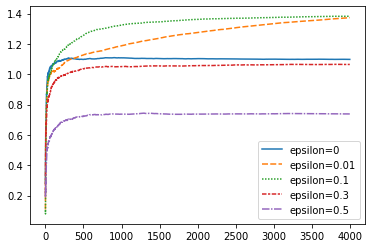

In [67]:
# Epsilon-greedy strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure()
sns.lineplot(data = RP1.reward_data)

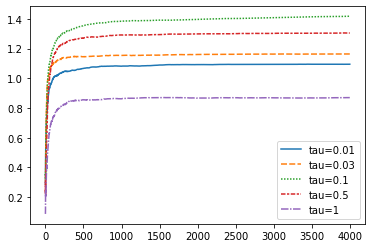

In [68]:
# Softmax strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure()
sns.lineplot(data = RP2.reward_data)

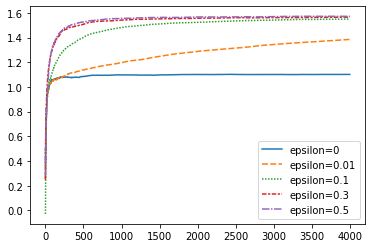

In [69]:
# Epsilon-greedy strategy, total average rewards under optimal actions
plt.figure()
sns.lineplot(data = RP1.optimal_action)

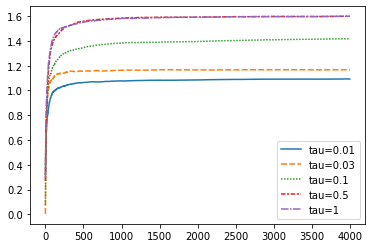

In [70]:
# Softmax strategy, total average rewards under optimal actions
plt.figure()
sns.lineplot(data = RP2.optimal_action)